## Habit adaptive ice crystal growth

Simple implementation of deposition growth for a single particle.
The particle is modeled as a spheroid, whose axis can evolve freely. 


### References
- Chen, J.-P., Lamb, D., 1994. The theoretical basis for the parameterization of ice crystal habits: Growth by vapor deposition. Journal of Atmospheric Sciences 51, 1206–1222. [doi:10.1175/1520-0469(1994)051<1206:TTBFTP>2.0.CO;2](https://doi.org/10.1175/1520-0469(1994)051<1206:TTBFTP>2.0.CO;2)
- Sulia, K.J., Harrington, J.Y., 2011. Ice aspect ratio influences on mixed-phase clouds: Impacts on phase partitioning in parcel models. J. Geophys. Res. 116. [doi:10.1029/2011JD016298](https://doi.org/10.1029/2011JD016298)
- Zhang, D., Wang, Z., Heymsfield, A., Fan, J., Luo, T., 2014. Ice Concentration Retrieval in Stratiform Mixed-Phase Clouds Using Cloud Radar Reflectivity Measurements and 1D Ice Growth Model Simulations. Journal of the Atmospheric Sciences 71, 3613–3635. [doi:10.1175/JAS-D-13-0354.1](https://doi.org/10.1175/JAS-D-13-0354.1)


<div class="alert alert-block alert-warning">
<b>Disclaimer:</b> 
    
The results are rather sensitive to the choice of inherent growth ratio (IGR) and $\varrho_\mathrm{dep}$.
The information in the articles on both parameters is rather vague and sometimes contradicting.
For a comparision of available parameters, see <a href='plot_IGR_dep_density.ipynb'>plot_IGR_dep_density.ipynb</a>
    
To validate this implementation I only compared the results with figures given in the respective publications.
However, no one-to-one comparison of intermediate steps was performed. 
    
Also the growth enhancement due to the ventilation factor could not be verified.
</div>

In [119]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
import numpy as np

import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt

import analytic_formulas as af
import aux_data as aux

In [121]:
%matplotlib inline

In [122]:
Ts = np.arange(-40,0,7)
Ts = -10

params = dict(Lw='RY', Li='RY', rho_w='HS', D='HP', Ei='GG', Ew='GG')
params = dict()
f = af.get_factors(273.15+Ts, 750e2, rh=100, **params)

input kwargs:  {}


In [123]:
def calc_C(a,c):
    """calculate the capacitance for a given major and minor axis"""
    Phi = c/a
    
    if np.isclose(c,a): #spherical
        C = a
    elif Phi < 1: #oblate
        epsilon = np.sqrt(1-Phi**2)
        C = a*epsilon/np.arcsin(epsilon)
    elif Phi > 1: #prolate
        epsilon = np.sqrt(1-Phi**(-2))
        C = c*epsilon/np.log((1+epsilon)*Phi)
    else: #speherical
        raise ValueError()
    return C


# g = 9.81
# # dynamic viscosity
# eta_air = 1.8e-5 #kg/ ms
# #kinematic viscosity
# nu = 1.47e-5 #m2/s

def calc_Dmax_proj_Area(a,c, rho_ic, rho_bulkice=910):
    """for Dmax Böhm 1992, after Zhang 2014 and for Ar Harrington ?
    
    rho_ic: ice crystal density
    
    """

    if np.isclose(c,a): # spherical
        Dmax = 2*a
        A = np.pi*a**2
    elif c/a < 1:
        #oblate/plate
        Dmax = 2*a
        A = np.pi*a**2*(rho_ic/rho_bulkice)
    elif c/a > 1:
        #prolate/column like
        Dmax = 2*np.sqrt(a*c)
        A = np.pi*a*c
    else:
        print(a,c)
        raise ValueError()
        
    Ar = A/(np.pi/4*Dmax**2)
#     print(f" a {a*1e6:6.2f}µm c {c*1e6:6.2f}µm   Dmax {Dmax:6.3e} m   Ar {Ar:10.3e}")
    return Dmax, Ar

    
def calc_Re(Best_no):
    """calculate the Reynolds number from the best number"""
    g0 = 8.0
    g1 = 0.35
    brack = ((1+(4*np.sqrt(Best_no))/(g0**2*np.sqrt(g1)))**0.5-1)**2
    #print("Re ", 0.25*g0**2*brack)
    return 0.25*g0**2*brack

def calc_Best(m_p, A_r, g, rho_air, eta_air):
    """calculate the Best number"""
    # from Heymsfield and Westbrook 2010
    k = 0.5
    n = 8*m_p*g*rho_air 
    # the formula given in zhang is missing the pi
    d = np.pi*eta_air**2*A_r**(1-k)
    #print("best no ", A_r, d, n, d/n)
    return n/d

def calc_fv(Re):
    """calculate the ventilation factor"""
    Sc = 0.632 #Schmidt number
    X = Sc**(1/3)*Re**(1/2)
    
    if X > 1.0:
        fv = 0.86 + 0.28*X
    else:
        fv = 1 + 0.14*X**2
    return fv    


def growth_factor_kinetic_correction(f, r):
    
    delv = 1.3*8.e-8
    alpc = 0.036
    
    D = 0.211e-4*(f.T/273.15)**1.94*(101325./f.p)
    # modified diffusivity
    D_mod = D/(r/(r+delv)+D/(r*alpc)*np.sqrt(2.*np.pi/(af.Rv*f.T)))
    
    delt = 2.16e-7
    alpt = 0.7
    ka = (5.69+0.017*(f.T-273.15))*1e-5*1e2*4.18684
    ka_mod = ka/(r/(r+delt)+ka/(r*alpt*f.rho_a*f.cp)*np.sqrt(2.*np.pi/(af.Ra*f.T)))
    
    Ai_diff = 1.0/((af.rho_i*af.Rv*f.T/(f.Ei*D_mod))+f.Li*af.rho_i/(f.T*ka_mod)*(f.Li/(f.T*af.Rv)-1.))
    return Ai_diff


def grow_particle(a,c,f, tmax, 
                  rho_dep='C94', igr='H08col',
                  verbose=False, force_sphere=False):

    Si = f.ksi
    # initially we have a solid sphere
    V = 4/3*np.pi*a**2*c
    m = V*af.rho_i
    print(f"start: a {a*1e6:6.2f}µm c {c*1e6:6.2f}µm   V {V:10.3e} m3   m {m:10.3e} kg")
    part_hist = []
    
    Phi = c/a
    dt = 2

    for i in np.arange(0,tmax+1,dt):

        print(f"step {i:4} -- a {a*1e6:6.2f}µm c {c*1e6:6.2f}µm   V {V:10.3e} m3   m {m:10.3e} kg") if verbose else None
#         print(f"step {i:4} -- a {a*1e6:6.2f}µm c {c*1e6:6.2f}µm   V {V:10.3e} m3   m {m:10.3e} kg")
#         Phi = c/a
#         V = 4/3*np.pi*a**2*c

        rho_ic = m/V
        print(Phi, '< 1 oblate, > 1 prolate   | rho_ic', rho_ic) if verbose else None

        Dmax, Ar = calc_Dmax_proj_Area(a, c, rho_ic, rho_bulkice=910)
        Re = calc_Re(calc_Best(m, Ar, af.g, f.rho_a, f.eta_a))
        fv = calc_fv(Re)
        fv = 1
#         print('Re ', Re, ' fv ', fv)

        print("Supersat over ice ", Si) if verbose else None
        C = calc_C(a,c)
        print('C ', C) if verbose else None
#         V = 4/3*np.pi*a**2*c
        #
        # in the end rho_i vanishes as it also appears in f.Ai
        dmdt = (4*np.pi*C*(Si-1)*fv*af.rho_i)*f.Ai*dt
        dmdt = (4*np.pi*C*(Si-1)*fv*af.rho_i)*f.Ai_alt*dt
#         dmdt = (4*np.pi*C*(Si-1)*fv*af.rho_i)*growth_factor_kinetic_correction(f, a)*dt
        print('mass change ', dmdt) if verbose else None

        if not force_sphere:
            igr_here = aux.get_igr(f.T, igr)
            
            # in g m-3
            rho_exwv = (f.e0 - f.Ei)/(af.Rv*f.T)
            print('rho_exwv ', rho_exwv, rho_exwv*1e3) if verbose else None
            if rho_dep=='C94':

                igr_density = aux.get_igr(f.T, 'C94')
                # originally g cm-3, convert to kg m-3
                rho_dep = 0.91*np.exp(-3*(np.maximum(rho_exwv*1e3-0.05, 0))/igr_density)*1e3
            elif rho_dep=='M79':
            # very original one, but wrong in the chen context
                rho_dep = np.interp(f.T-273.15, TsIGR, rho_dep_Miller)*1e3

            dVdt = dmdt/rho_dep
            Phi_new = Phi*((V+dVdt)/V)**((igr_here-1)/(igr_here+2))

        else:
            igr_here = 1
            rho_dep = af.rho_i
            dVdt = dmdt/rho_dep
            Phi_new = 1

        part_hist.append({
            't': i, 'm':m, 'a':a, 'c':c, 'V':V,
            'rho_ic': rho_ic,
            'C': C, 'Re': Re, 'Dmax': Dmax, 'igr_here': igr_here
        })

        print('igr', igr_here) if verbose else None
        print(f'rho_dep {rho_dep} kg m-3') if verbose else None
#         print(f'rho_dep {rho_dep} kg m-3 ', 'igr', igr_here, 'volume change', dVdt)
        print('volume change', dVdt) if verbose else None

        a_new = (3/(4*np.pi)*(V+dVdt)/Phi_new)**(1/3)
        c_new = Phi_new*a_new
        print(f"Phi_new {Phi_new:.2e} a {a_new*1e6:6.2f}µm c {c_new*1e6:6.2f}µm") if verbose else None

        a = a_new
        c = c_new
        m = m+dmdt
        V = V+dVdt
        Phi = Phi_new
        
    print(f'rho_dep {rho_dep} kg m-3')
    print(f"end  : a {a*1e6:6.2f}µm c {c*1e6:6.2f}µm   V {V:10.3e} m3   m {m:10.3e} kg")
    return part_hist




a = 2e-6
c = 2e-6

Tis = np.arange(-35, 0, 1)
collect = {}
collectSP = {}
# Tis = [-10, -15]
for Ti in Tis:
    print(f"===  {Ti} =======================================")
    f = af.get_factors(273.15+Ti, 750e2, rh=100, **params)
    collect[Ti] = grow_particle(a,c,f,25*60, igr='C94', verbose=False, force_sphere=False)
    collectSP[Ti] = grow_particle(a,c,f,25*60, igr='C94', verbose=False, force_sphere=True)
    
    
a = 6e-6
c = 6e-6

collect6 = {}
# Tis = [-10, -15]
for Ti in Tis:
    print(f"===  {Ti} =======================================")
    f = af.get_factors(273.15+Ti, 750e2, rh=100, **params)
    collect6[Ti] = grow_particle(a,c,f,25*60, igr='C94', verbose=False, force_sphere=False)
    
a = 12e-6
c = 12e-6

collect12 = {}
# Tis = [-10, -15]
for Ti in Tis:
    print(f"===  {Ti} =======================================")
    f = af.get_factors(273.15+Ti, 750e2, rh=100, **params)
    collect12[Ti] = grow_particle(a,c,f,25*60, igr='C94', verbose=False, force_sphere=False)
    

===  -35 =======================================
input kwargs:  {}
start: a   2.00µm c   2.00µm   V  3.351e-17 m3   m  3.083e-14 kg
rho_dep 841.1802019103827 kg m-3
end  : a  62.83µm c 135.90µm   V  2.247e-12 m3   m  1.890e-09 kg
start: a   2.00µm c   2.00µm   V  3.351e-17 m3   m  3.083e-14 kg
rho_dep 920 kg m-3
end  : a  76.13µm c  76.13µm   V  1.849e-12 m3   m  1.701e-09 kg
===  -34 =======================================
input kwargs:  {}
start: a   2.00µm c   2.00µm   V  3.351e-17 m3   m  3.083e-14 kg
rho_dep 829.0319186631486 kg m-3
end  : a  65.43µm c 142.83µm   V  2.561e-12 m3   m  2.123e-09 kg
start: a   2.00µm c   2.00µm   V  3.351e-17 m3   m  3.083e-14 kg
rho_dep 920 kg m-3
end  : a  78.91µm c  78.91µm   V  2.058e-12 m3   m  1.894e-09 kg
===  -33 =======================================
input kwargs:  {}
start: a   2.00µm c   2.00µm   V  3.351e-17 m3   m  3.083e-14 kg
rho_dep 816.4976246436851 kg m-3
end  : a  68.09µm c 149.98µm   V  2.913e-12 m3   m  2.378e-09 kg
start: a   2

rho_dep 920 kg m-3
end  : a 115.59µm c 115.59µm   V  6.470e-12 m3   m  5.952e-09 kg
===  -12 =======================================
input kwargs:  {}
start: a   2.00µm c   2.00µm   V  3.351e-17 m3   m  3.083e-14 kg
rho_dep 297.3197015690207 kg m-3
end  : a 744.62µm c  32.21µm   V  7.480e-11 m3   m  2.224e-08 kg
start: a   2.00µm c   2.00µm   V  3.351e-17 m3   m  3.083e-14 kg
rho_dep 920 kg m-3
end  : a 114.47µm c 114.47µm   V  6.284e-12 m3   m  5.781e-09 kg
===  -11 =======================================
input kwargs:  {}
start: a   2.00µm c   2.00µm   V  3.351e-17 m3   m  3.083e-14 kg
rho_dep 400.87859875621166 kg m-3
end  : a 358.00µm c  54.12µm   V  2.905e-11 m3   m  1.165e-08 kg
start: a   2.00µm c   2.00µm   V  3.351e-17 m3   m  3.083e-14 kg
rho_dep 920 kg m-3
end  : a 112.85µm c 112.85µm   V  6.020e-12 m3   m  5.538e-09 kg
===  -10 =======================================
input kwargs:  {}
start: a   2.00µm c   2.00µm   V  3.351e-17 m3   m  3.083e-14 kg
rho_dep 506.0895793174673

rho_dep 530.1237630974921 kg m-3
end  : a 195.15µm c  90.90µm   V  1.450e-11 m3   m  7.688e-09 kg
===  -19 =======================================
input kwargs:  {}
start: a   6.00µm c   6.00µm   V  9.048e-16 m3   m  8.324e-13 kg
rho_dep 413.2246933611572 kg m-3
end  : a 336.04µm c  57.36µm   V  2.713e-11 m3   m  1.121e-08 kg
===  -18 =======================================
input kwargs:  {}
start: a   6.00µm c   6.00µm   V  9.048e-16 m3   m  8.324e-13 kg
rho_dep 304.2607935628768 kg m-3
end  : a 582.25µm c  41.36µm   V  5.873e-11 m3   m  1.787e-08 kg
===  -17 =======================================
input kwargs:  {}
start: a   6.00µm c   6.00µm   V  9.048e-16 m3   m  8.324e-13 kg
rho_dep 213.96276774125485 kg m-3
end  : a 999.80µm c  32.73µm   V  1.370e-10 m3   m  2.932e-08 kg
===  -16 =======================================
input kwargs:  {}
start: a   6.00µm c   6.00µm   V  9.048e-16 m3   m  8.324e-13 kg
rho_dep 163.64222762877662 kg m-3
end  : a 1438.32µm c  29.21µm   V  2.531e-10 

rho_dep 213.96276774125485 kg m-3
end  : a 725.51µm c  46.77µm   V  1.031e-10 m3   m  2.207e-08 kg
===  -16 =======================================
input kwargs:  {}
start: a  12.00µm c  12.00µm   V  7.238e-15 m3   m  6.659e-12 kg
rho_dep 163.64222762877662 kg m-3
end  : a 1003.54µm c  43.10µm   V  1.818e-10 m3   m  2.976e-08 kg
===  -15 =======================================
input kwargs:  {}
start: a  12.00µm c  12.00µm   V  7.238e-15 m3   m  6.659e-12 kg
rho_dep 141.64640863346204 kg m-3
end  : a 1176.66µm c  42.03µm   V  2.437e-10 m3   m  3.453e-08 kg
===  -14 =======================================
input kwargs:  {}
start: a  12.00µm c  12.00µm   V  7.238e-15 m3   m  6.659e-12 kg
rho_dep 156.3889444558973 kg m-3
end  : a 1020.57µm c  44.34µm   V  1.935e-10 m3   m  3.026e-08 kg
===  -13 =======================================
input kwargs:  {}
start: a  12.00µm c  12.00µm   V  7.238e-15 m3   m  6.659e-12 kg
rho_dep 212.63106306811179 kg m-3
end  : a 674.61µm c  51.25µm   V  9.770e

In [124]:
# rho_dep 530.9529500969063 kg m-3
# end  : a 184.22µm c 146.43µm   V  2.082e-11 m3   m  1.105e-08 kg
# wrong deposition density
# rho_dep 348.6809296218214 kg m-3
# end  : a 239.94µm c 187.73µm   V  4.527e-11 m3   m  1.579e-08 kg

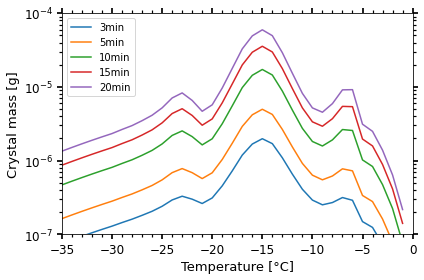

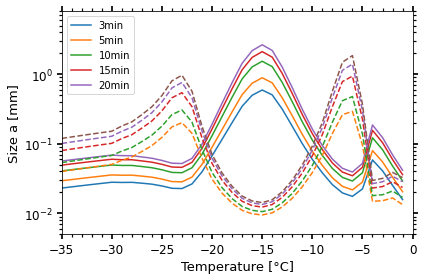

In [125]:
def gfl(l, k, t):
    """get from list"""
    return np.array([e[k] for e in l if np.isin(e['t'], t)])

fig, ax = plt.subplots(figsize=(6, 4))

ms = np.array([gfl(ph, 'm', [3*60]) for ph in collect.values()])
ax.plot(Tis, ms*1e3, label='3min')
ms = np.array([gfl(ph, 'm', [5*60]) for ph in collect.values()])
ax.plot(Tis, ms*1e3, label='5min')
ms = np.array([gfl(ph, 'm', [10*60]) for ph in collect.values()])
ax.plot(Tis, ms*1e3, label='10min')
ms = np.array([gfl(ph, 'm', [15*60]) for ph in collect.values()])
ax.plot(Tis, ms*1e3, label='15min')
ms = np.array([gfl(ph, 'm', [20*60]) for ph in collect.values()])
ax.plot(Tis, ms*1e3, label='20min')

# ms = np.array([gfl(ph, 'm', [25*60]) for ph in collect.values()])
# ax.plot(Tis, ms*1e3, label='25min')

ax.set_yscale('log')
ax.set_ylim(5e-9, 4e-4)
ax.set_ylim(1e-7, 1e-4)
# ax.set_xlim(-2, -24)
ax.set_xlim(-35, -0)

ax.set_ylabel('Crystal mass [g]', fontsize=13)

ax.set_xlabel('Temperature [°C]', fontsize=13)

ax.tick_params(axis='both', which='both', right=True, top=True)
ax.tick_params(axis='both', which='major', labelsize=12,
               width=1.7, length=5)
ax.tick_params(axis='both', which='minor', width=1.2, length=3)
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
# ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.legend()

fig.tight_layout()
fig.savefig('comparisons/ice_mass_fukuta.png', dpi=250, transparent=True)


fig, ax = plt.subplots(figsize=(6, 4))

ms = np.array([gfl(ph, 'a', [3*60]) for ph in collect.values()])
ax.plot(Tis, ms*1e3, label='3min')
ms = np.array([gfl(ph, 'a', [5*60]) for ph in collect.values()])
ax.plot(Tis, ms*1e3, label='5min')
ms = np.array([gfl(ph, 'a', [10*60]) for ph in collect.values()])
ax.plot(Tis, ms*1e3, label='10min')
ms = np.array([gfl(ph, 'a', [15*60]) for ph in collect.values()])
ax.plot(Tis, ms*1e3, label='15min')
ms = np.array([gfl(ph, 'a', [20*60]) for ph in collect.values()])
ax.plot(Tis, ms*1e3, label='20min')
# ms = np.array([gfl(ph, 'a', [25*60]) for ph in collect.values()])
# ax.plot(Tis, ms*1e3, label='25min')

ms = np.array([gfl(ph, 'c', [3*60]) for ph in collect.values()])
ax.plot(Tis, ms*1e3, '--', color='C1')
ms = np.array([gfl(ph, 'c', [5*60]) for ph in collect.values()])
ax.plot(Tis, ms*1e3, '--', color='C2')
ms = np.array([gfl(ph, 'c', [10*60]) for ph in collect.values()])
ax.plot(Tis, ms*1e3, '--', color='C3')
ms = np.array([gfl(ph, 'c', [15*60]) for ph in collect.values()])
ax.plot(Tis, ms*1e3, '--', color='C4')
ms = np.array([gfl(ph, 'c', [20*60]) for ph in collect.values()])
ax.plot(Tis, ms*1e3, '--', color='C5')
# ms = np.array([gfl(ph, 'c', [25*60]) for ph in collect.values()])
# ax.plot(Tis, ms*1e3, '--', color='C6')


ax.set_yscale('log')
ax.set_ylim(5e-3, 8)
# ax.set_xlim(-2, -24)
ax.set_xlim(-35, -0)

ax.set_ylabel('Size a [mm]', fontsize=13)

ax.set_xlabel('Temperature [°C]', fontsize=13)

ax.tick_params(axis='both', which='both', right=True, top=True)
ax.tick_params(axis='both', which='major', labelsize=12,
               width=1.7, length=5)
ax.tick_params(axis='both', which='minor', width=1.2, length=3)
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
# ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.legend()

fig.tight_layout()
fig.savefig('comparisons/size_ac_fukuta.png', dpi=250, transparent=True)


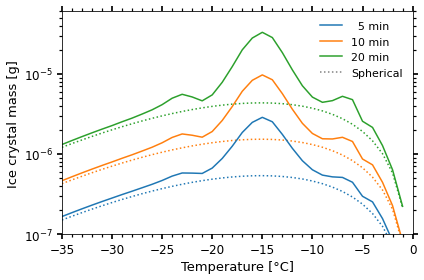

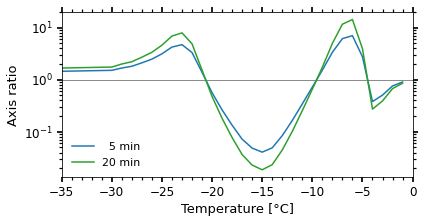

In [142]:
def gfl(l, k, t):
    """get from list"""
    return np.array([e[k] for e in l if np.isin(e['t'], t)])

fig, ax = plt.subplots(figsize=(6, 4))


ms = np.array([gfl(ph, 'm', [5*60]) for ph in collectSP.values()])
ax.plot(Tis, ms*1e3, c='C0', ls=':')
ms = np.array([gfl(ph, 'm', [10*60]) for ph in collectSP.values()])
ax.plot(Tis, ms*1e3, c='C1', ls=':')
ms = np.array([gfl(ph, 'm', [20*60]) for ph in collectSP.values()])
ax.plot(Tis, ms*1e3, c='C2', ls=':')


ms = np.array([gfl(ph, 'm', [5*60]) for ph in collect6.values()])
ax.plot(Tis, ms*1e3, c='C0', ls='-', label='  5 min')
ms = np.array([gfl(ph, 'm', [10*60]) for ph in collect6.values()])
ax.plot(Tis, ms*1e3, c='C1', ls='-', label='10 min')
ms = np.array([gfl(ph, 'm', [20*60]) for ph in collect6.values()])
ax.plot(Tis, ms*1e3, c='C2', ls='-', label='20 min')



ax.set_yscale('log')
ax.set_ylim(5e-9, 4e-4)
ax.set_ylim(1e-7, 6e-5)
# ax.set_xlim(-2, -24)
ax.set_xlim(-35, -0)

ax.set_ylabel('Ice crystal mass [g]', fontsize=13)

ax.set_xlabel('Temperature [°C]', fontsize=13)

ax.tick_params(axis='both', which='both', right=True, top=True)
ax.tick_params(axis='both', which='major', labelsize=12,
               width=1.7, length=5)
ax.tick_params(axis='both', which='minor', width=1.2, length=3)
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
# ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())

handles, _ = ax.get_legend_handles_labels()
patch = matplotlib.lines.Line2D([0], [0], color='grey', linestyle=':', label='Spherical')
handles.append(patch) 
ax.legend(handles=handles, loc='upper right', fontsize=11, frameon=False)


fig.tight_layout()
fig.savefig('plots/ice_mass.png', dpi=250, transparent=True)


fig, ax = plt.subplots(figsize=(6, 3.2))

ax.axhline(1, color='grey', lw=0.9)

a = np.array([gfl(ph, 'a', [5*60]) for ph in collect6.values()])
c = np.array([gfl(ph, 'c', [5*60]) for ph in collect6.values()])
ax.plot(Tis, c/a, c='C0', label='  5 min')
a = np.array([gfl(ph, 'a', [20*60]) for ph in collect6.values()])
c = np.array([gfl(ph, 'c', [20*60]) for ph in collect6.values()])
ax.plot(Tis, c/a, c='C2', label='20 min')

handles, labels = ax.get_legend_handles_labels()

ax.set_yscale('log')
# ax.set_ylim(5e-3, 8)
# ax.set_xlim(-2, -24)
ax.set_xlim(-35, -0)

ax.set_ylabel('Axis ratio', fontsize=13)
ax.set_xlabel('Temperature [°C]', fontsize=13)

ax.tick_params(axis='both', which='both', right=True, top=True)
ax.tick_params(axis='both', which='major', labelsize=12,
               width=1.7, length=5)
ax.tick_params(axis='both', which='minor', width=1.2, length=3)
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
# ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.legend(handles=handles, loc='lower left', fontsize=11, frameon=False)

fig.tight_layout()
fig.savefig('plots/ice_axis_ratio.png', dpi=250, transparent=True)


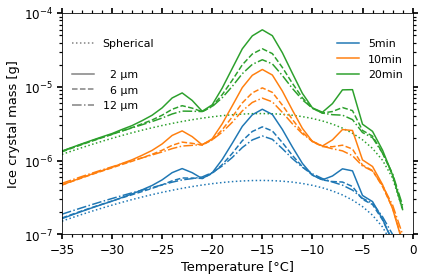

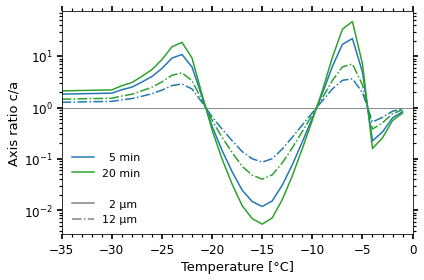

In [130]:
def gfl(l, k, t):
    """get from list"""
    return np.array([e[k] for e in l if np.isin(e['t'], t)])

fig, ax = plt.subplots(figsize=(6, 4))


ms = np.array([gfl(ph, 'm', [5*60]) for ph in collectSP.values()])
ax.plot(Tis, ms*1e3, c='C0', ls=':')
ms = np.array([gfl(ph, 'm', [20*60]) for ph in collectSP.values()])
ax.plot(Tis, ms*1e3, c='C2', ls=':')

ms = np.array([gfl(ph, 'm', [5*60]) for ph in collect12.values()])
ax.plot(Tis, ms*1e3, c='C0', ls='-.')
ms = np.array([gfl(ph, 'm', [10*60]) for ph in collect12.values()])
ax.plot(Tis, ms*1e3, c='C1', ls='-.')
ms = np.array([gfl(ph, 'm', [20*60]) for ph in collect12.values()])
ax.plot(Tis, ms*1e3, c='C2', ls='-.')

ms = np.array([gfl(ph, 'm', [5*60]) for ph in collect6.values()])
ax.plot(Tis, ms*1e3, c='C0', ls='--')
ms = np.array([gfl(ph, 'm', [10*60]) for ph in collect6.values()])
ax.plot(Tis, ms*1e3, c='C1', ls='--')
ms = np.array([gfl(ph, 'm', [20*60]) for ph in collect6.values()])
ax.plot(Tis, ms*1e3, c='C2', ls='--')

ms = np.array([gfl(ph, 'm', [5*60]) for ph in collect.values()])
ax.plot(Tis, ms*1e3, c='C0', label='5min')
ms = np.array([gfl(ph, 'm', [10*60]) for ph in collect.values()])
ax.plot(Tis, ms*1e3, c='C1', label='10min')
ms = np.array([gfl(ph, 'm', [20*60]) for ph in collect.values()])
ax.plot(Tis, ms*1e3, c='C2', label='20min')





ax.set_yscale('log')
ax.set_ylim(5e-9, 4e-4)
ax.set_ylim(1e-7, 1e-4)
# ax.set_xlim(-2, -24)
ax.set_xlim(-35, -0)

ax.set_ylabel('Ice crystal mass [g]', fontsize=13)

ax.set_xlabel('Temperature [°C]', fontsize=13)

ax.tick_params(axis='both', which='both', right=True, top=True)
ax.tick_params(axis='both', which='major', labelsize=12,
               width=1.7, length=5)
ax.tick_params(axis='both', which='minor', width=1.2, length=3)
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
# ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())

handles1, _ = ax.get_legend_handles_labels()
handles1.insert(0, matplotlib.patches.Patch(visible=False))
leg1 = ax.legend(handles=handles1, loc='upper right', fontsize=11, frameon=False)

#handles, labels = ax.get_legend_handles_labels()
handles = []
# manually define a new patch 
patch = matplotlib.lines.Line2D([0], [0], color='grey', linestyle=':', label='Spherical')
# handles is a list, so append manual patch
handles.append(matplotlib.patches.Patch(visible=False)) 
handles.append(patch) 
handles.append(matplotlib.patches.Patch(visible=False)) 
patch = matplotlib.lines.Line2D([0], [0], color='grey', linestyle='-', label='  2 µm')
handles.append(patch) 
patch = matplotlib.lines.Line2D([0], [0], color='grey', linestyle='--', label='  6 µm')
handles.append(patch) 
patch = matplotlib.lines.Line2D([0], [0], color='grey', linestyle='-.', label='12 µm')
handles.append(patch) 

leg2 = ax.legend(handles=handles, loc='upper left', fontsize=11, frameon=False)
ax.add_artist(leg1)

fig.tight_layout()
fig.savefig('plots/ice_mass_droplet_size.png', dpi=250, transparent=True)


fig, ax = plt.subplots(figsize=(6, 4))

ax.axhline(1, color='grey', lw=0.9)

a = np.array([gfl(ph, 'a', [5*60]) for ph in collect12.values()])
c = np.array([gfl(ph, 'c', [5*60]) for ph in collect12.values()])
ax.plot(Tis, c/a, c='C0', ls='-.')
a = np.array([gfl(ph, 'a', [20*60]) for ph in collect12.values()])
c = np.array([gfl(ph, 'c', [20*60]) for ph in collect12.values()])
ax.plot(Tis, c/a, c='C2', ls='-.')

a = np.array([gfl(ph, 'a', [5*60]) for ph in collect.values()])
c = np.array([gfl(ph, 'c', [5*60]) for ph in collect.values()])
ax.plot(Tis, c/a, c='C0', label='  5 min')
a = np.array([gfl(ph, 'a', [20*60]) for ph in collect.values()])
c = np.array([gfl(ph, 'c', [20*60]) for ph in collect.values()])
ax.plot(Tis, c/a, c='C2', label='20 min')

handles, labels = ax.get_legend_handles_labels()
# manually define a new patch 
handles.append(matplotlib.patches.Patch(visible=False)) 
patch = matplotlib.lines.Line2D([0], [0], color='grey', linestyle='-', label='  2 µm')
handles.append(patch) 
patch = matplotlib.lines.Line2D([0], [0], color='grey', linestyle='-.', label='12 µm')
# handles is a list, so append manual patch
handles.append(patch) 

ax.set_yscale('log')
# ax.set_ylim(5e-3, 8)
# ax.set_xlim(-2, -24)
ax.set_xlim(-35, -0)

ax.set_ylabel('Axis ratio c/a', fontsize=13)
ax.set_xlabel('Temperature [°C]', fontsize=13)

ax.tick_params(axis='both', which='both', right=True, top=True)
ax.tick_params(axis='both', which='major', labelsize=12,
               width=1.7, length=5)
ax.tick_params(axis='both', which='minor', width=1.2, length=3)
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
# ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.legend(handles=handles, loc='lower left', fontsize=11, frameon=False)

fig.tight_layout()
fig.savefig('plots/ice_axis_ratio_droplet_size.png', dpi=250, transparent=True)


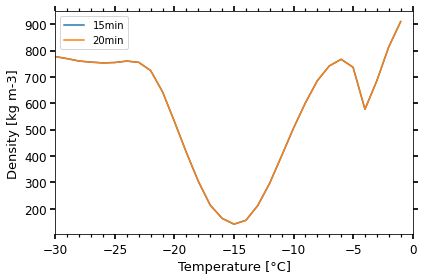

In [127]:
fig, ax = plt.subplots(figsize=(6, 4))

# ms = np.array([gfl(ph, 'm', [1*60]) for ph in collect.values()])
# ax.plot(Tis, ms*1e3, label='1min')
# ms = np.array([gfl(ph, 'm', [3*60]) for ph in collect.values()])
# ax.plot(Tis, ms*1e3, label='3min')
# ms = np.array([gfl(ph, 'm', [5*60]) for ph in collect.values()])
# ax.plot(Tis, ms*1e3, label='5min')
# ms = np.array([gfl(ph, 'm', [10*60]) for ph in collect.values()])
# ax.plot(Tis, ms*1e3, label='10min')
ms = np.array([gfl(ph, 'rho_ic', [15*60]) for ph in collect.values()])
ax.plot(Tis, ms, label='15min')
ms = np.array([gfl(ph, 'rho_ic', [20*60]) for ph in collect.values()])
ax.plot(Tis, ms, label='20min')

# ms = np.array([gfl(ph, 'm', [25*60]) for ph in collect.values()])
# ax.plot(Tis, ms*1e3, label='25min')

# ax.set_yscale('log')
# ax.set_ylim(5e-9, 2e-4)
# ax.set_ylim(7e-7, 2e-5)
# ax.set_xlim(-2, -24)
ax.set_xlim(-30, -0)

ax.set_ylabel('Density [kg m-3]', fontsize=13)

ax.set_xlabel('Temperature [°C]', fontsize=13)

ax.tick_params(axis='both', which='both', right=True, top=True)
ax.tick_params(axis='both', which='major', labelsize=12,
               width=1.7, length=5)
ax.tick_params(axis='both', which='minor', width=1.2, length=3)
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
# ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.legend()

fig.tight_layout()
# fig.savefig('comparisons/ice_mass_fukuta.png', dpi=250, transparent=True)

In [128]:
Tis1 = [-10, -15]

collect1 = {}
collect2 = {}

for Ti in Tis1:
    print(f"===  {Ti} =======================================")
    f = af.get_factors(273.15+Ti, 750e2, rh=100, **params)
    collect1[Ti] = grow_particle(a,c,f,25*60, verbose=False, force_sphere=False)
    
    collect2[Ti] = grow_particle(a,c,f,25*60, igr="C94", verbose=False, force_sphere=False)


def gfl(l, k):
    """get from list"""
    return np.array([e[k] for e in l])

fig, ax = plt.subplots(figsize=(4.8, 4))

ax.plot(gfl(collect1[-10], 't'), gfl(collect1[-10], 'm')*1e3)
ax.plot(gfl(collect1[-15], 't'), gfl(collect1[-15], 'm')*1e3)

ax.plot(gfl(collect2[-10], 't'), gfl(collect2[-10], 'm')*1e3)
ax.plot(gfl(collect2[-15], 't'), gfl(collect2[-15], 'm')*1e3)
ax.set_ylabel('mass')

fig, ax = plt.subplots(figsize=(4.8, 4))

ax.plot(gfl(collect1[-10], 't'), gfl(collect1[-10], 'V'))
ax.plot(gfl(collect1[-15], 't'), gfl(collect1[-15], 'V'))
ax.plot(gfl(collect2[-10], 't'), gfl(collect2[-10], 'V'))
ax.plot(gfl(collect2[-15], 't'), gfl(collect2[-15], 'V'))
ax.set_ylabel('V')


fig, ax = plt.subplots(figsize=(4.8, 4))

ax.plot(gfl(collect1[-10], 't'), gfl(collect1[-10], 'igr_here'))
ax.plot(gfl(collect1[-15], 't'), gfl(collect1[-15], 'igr_here'))
ax.set_ylabel('IGR')

fig, ax = plt.subplots(figsize=(4.8, 4))

ax.plot(gfl(collect1[-10], 't'), gfl(collect1[-10], 'C'))
ax.plot(gfl(collect1[-15], 't'), gfl(collect1[-15], 'C'))
ax.set_ylabel('C')

fig, ax = plt.subplots(figsize=(4.8, 4))

ax.plot(gfl(collect1[-10], 't'), gfl(collect1[-10], 'rho_ic'))
ax.plot(gfl(collect1[-15], 't'), gfl(collect1[-15], 'rho_ic'))

ax.plot(gfl(collect2[-10], 't'), gfl(collect2[-10], 'rho_ic'))
ax.plot(gfl(collect2[-15], 't'), gfl(collect2[-15], 'rho_ic'))
ax.set_ylabel('rho_ic')



fig, ax = plt.subplots(figsize=(4.8, 4))

ax.plot(gfl(collect[-10], 't'), gfl(collect[-10], 'a')*1e6, '-', color='C0')
ax.plot(gfl(collect[-10], 't'), gfl(collect[-10], 'c')*1e6, ':', color='C0')

ax.plot(gfl(collect[-15], 't'), gfl(collect[-15], 'a')*1e6, '-', color='C1')
ax.plot(gfl(collect[-15], 't'), gfl(collect[-15], 'c')*1e6, ':', color='C1')
ax.set_ylabel('Size')

===  -10 =======================================
input kwargs:  {}


TypeError: unsupported format string passed to numpy.ndarray.__format__